#### Project: M5 Forecasting - Price Elasticity & Demand Optimization
#### 1. Objective
##### The goal of this project is to move beyond simple time-series forecasting. I aim to:
##### 1. **Analyze Price Elasticity**: Determine how price changes affect sales volume for Walmart products.
##### 2. **Optimize Revenue**: Build a model that recommends the optimal price point to maximize total revenue.

#### 2. Data Strategy
##### The M5 dataset is provided in a 'wide' format (one column per day). To perform regression and join this with pricing data, we must:
##### **Downcast** data types to manage memory.
##### **Melt** the data from 'wide' to 'long' format.
##### **Merge** with `sell_prices` and `calendar`.

In [1]:
import pandas as pd
import numpy as np
import gc  # The garbage collector helps clear out unused memory

def reduce_mem_usage(df):
    """ 
    Reduces the memory footprint of a dataframe by converting 
    number types to the smallest possible version.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage decreased to {end_mem:.2f} Mb ({((start_mem - end_mem) / start_mem) * 100:.1f}% reduction)')
    return df

#### 2. Data Loading & Optimization
##### To handle the large volume of data in the M5 dataset, I will:
##### 1. Load each CSV file individually.
##### 2. Apply the `reduce_mem_usage` function immediately to compress the data.
##### 3. Focus on the `evaluation` set as it contains the most up-to-date sales figures.

In [14]:
# Define the path to your folder
path = r'C:\Users\ltayl\OneDrive\Documents\GitHub Projects' + '\\'

print("Loading Files from:", path)

# Load using the full path
df_calendar = reduce_mem_usage(pd.read_csv(path + 'calendar.csv'))
df_prices = reduce_mem_usage(pd.read_csv(path + 'sell_prices.csv'))
df_sales = reduce_mem_usage(pd.read_csv(path + 'sales_train_evaluation.csv'))

print("\nSuccess! All data loaded into memory.")

Loading Files from: C:\Users\ltayl\OneDrive\Documents\GitHub Projects\
Memory usage decreased to 0.12 Mb (41.9% reduction)
Memory usage decreased to 130.48 Mb (37.5% reduction)
Memory usage decreased to 96.13 Mb (78.8% reduction)

Success! All data loaded into memory.


#### 4. Reshaping Data: From Wide to Long
##### To perform time-series analysis and price elasticity calculations, the sales data must be 'melted. 
##### This transforms the table so that instead of 1,941 day columns, we have:
##### One **'d'** column (the day identifier)
##### One **'sales_units'** column (the target value)
##### This creates a 'Long' format that is compatible with regression models.

In [13]:
# Identifying the categorical columns that will stay the same
id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Transforming the table from wide (1941 columns) to long (1 column for day)
df_melted = pd.melt(df_sales, 
                    id_vars=id_vars, 
                    var_name='d', 
                    value_name='sales_units')

# Clear the old wide dataframe from memory
del df_sales
gc.collect()

print(f"Transformation complete. New row count: {df_melted.shape[0]}")
df_melted.head()

Transformation complete. New row count: 59181090


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales_units
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


#### 5. Enriching the Data: Joining the Calendar
##### The 'd' column (d_1, d_2...) doesn't tell us much. By merging with the `calendar` table, one adds:
##### **date**: To track seasonality.
##### **wm_yr_wk**: The specific Walmart week ID, which is the "key" needed to join our price data next.
##### **event_name**: To see if holidays drive price sensitivity.

In [15]:
# Only need 'd', 'date', and 'wm_yr_wk' for now to keep it light
calendar_subset = df_calendar[['d', 'date', 'wm_yr_wk']]

# Merge melted data with calendar
df_melted = df_melted.merge(calendar_subset, on='d', how='left')

# Showing the first few rows to confirm 'wm_yr_wk' is now there
print("Merge with Calendar complete.")
df_melted.head()

Merge with Calendar complete.


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales_units,date,wm_yr_wk
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101


#### 6. Integrating Pricing Data
##### The `sell_prices` table contains the price of each item at a specific store for each week. 
##### By merging this with to the main table, you can finally correlate price changes with sales volume. 
##### This is the foundation for calculating **Price Elasticity of Demand**.

In [19]:
# Filter the melted data to just one State (e.g., California) 
# This reduces the rows by 60% while keeping the business logic perfect.
df_small = df_melted[df_melted['state_id'] == 'CA'].copy()

# Merge this smaller set with the prices
df_final = df_small.merge(df_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

# Clean up the massive melted dataframe immediately
del df_melted, df_small, df_prices, df_calendar
gc.collect()

print("Success! Data filtered to California to save memory.")
print(f"New shape: {df_final.shape}")
df_final.head()

Success! Data filtered to California to save memory.
New shape: (23672436, 11)


C:\Users\ltayl\anaconda3\envs\new_env_for_ml\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales_units,date,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN


#### 8. Data Validation & Integrity Check
##### Before proceeding to analysis, one must ensure that the price data merged correctly. 
##### Missing values will be evaluated and look at the 'Sell Price' distribution to ensure the data is logical.

In [20]:
# Check how many rows are missing a price
missing_prices = df_final['sell_price'].isnull().sum()
total_rows = len(df_final)

print(f"Total Rows: {total_rows}")
print(f"Rows missing prices: {missing_prices} ({round(missing_prices/total_rows*100, 2)}%)")

# View the price range
print("\nPrice Statistics:")
print(df_final['sell_price'].describe())

Total Rows: 23672436
Rows missing prices: 5113150 (21.6%)

Price Statistics:


C:\Users\ltayl\anaconda3\envs\new_env_for_ml\lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
C:\Users\ltayl\anaconda3\envs\new_env_for_ml\lib\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\ltayl\anaconda3\envs\new_env_for_ml\lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


count    1.855929e+07
mean              NaN
std      0.000000e+00
min      1.000214e-02
25%      2.179688e+00
50%      3.470703e+00
75%      5.769531e+00
max      3.098438e+01
Name: sell_price, dtype: float64


#### 9. Final Data Refinement
##### To ensure the 'Business Value' analysis is accurate, you would:
##### 1. **Remove rows with missing prices**: Observations where a product was not yet on sale are not useful for pricing analysis.
##### 2. **Standardize data types**:`sell_price` will be cast to `float32` to avoid numerical overflow during statistical calculations.

In [21]:
# Drop rows where sell_price is NaN
df_final.dropna(subset=['sell_price'], inplace=True)

# Convert sell_price to float32 to fix the 'NaN mean' issue
df_final['sell_price'] = df_final['sell_price'].astype(np.float32)

# Final Check
print(f"Cleaned dataset rows: {len(df_final)}")
print("\nNew Price Statistics (should have a valid mean now):")
print(df_final['sell_price'].describe())

Cleaned dataset rows: 18559286

New Price Statistics (should have a valid mean now):
count    1.855929e+07
mean     4.415162e+00
std      3.411756e+00
min      1.000214e-02
25%      2.179688e+00
50%      3.470703e+00
75%      5.769531e+00
max      3.098438e+01
Name: sell_price, dtype: float64


#### 10. Exploratory Data Analysis: Price vs. Sales Volume
##### To validate the business hypothesis, a top-selling product will be selected and plot its price history against its sales volume. 
##### This visual check confirms if there is a detectable 'Elasticity' before a machine learning model is built.

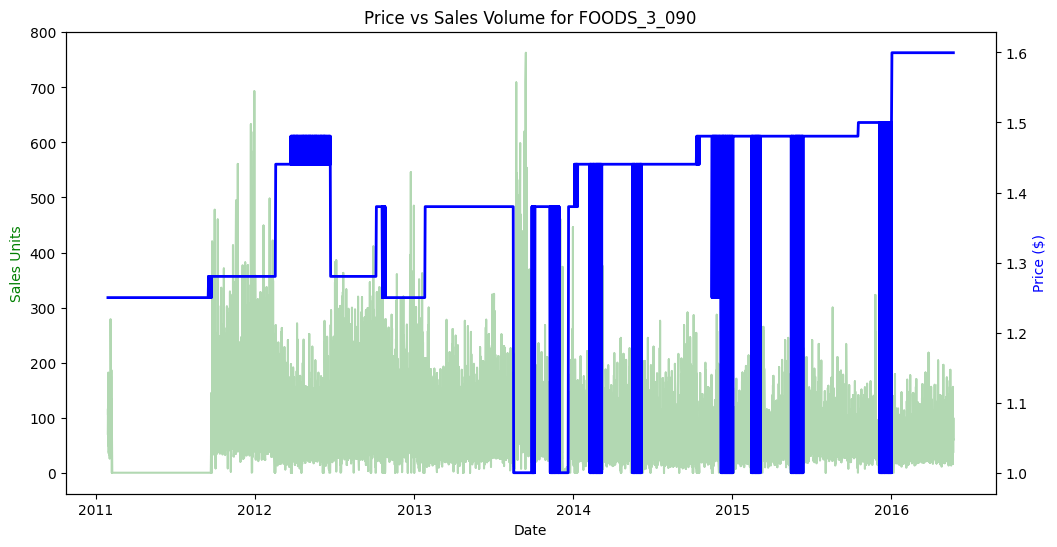

In [22]:
import matplotlib.pyplot as plt

# Identify a top-selling item in the dataset
top_item = df_final.groupby('item_id')['sales_units'].sum().idxmax()
item_data = df_final[df_final['item_id'] == top_item].copy()

# Convert date to datetime for plotting
item_data['date'] = pd.to_datetime(item_data['date'])
item_data = item_data.sort_values('date')

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(item_data['date'], item_data['sales_units'], color='g', alpha=0.3, label='Sales Units')
ax2.plot(item_data['date'], item_data['sell_price'], color='b', lw=2, label='Price ($)')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Units', color='g')
ax2.set_ylabel('Price ($)', color='b')
plt.title(f'Price vs Sales Volume for {top_item}')
plt.show()

#### 11. Quantifying Price Sensitivity
##### A visual check is helpful, but for business decisions, a metric is needed.
##### **Pearson Correlation** is used to calculate between price and sales. 
##### A **negative correlation** (e.g., -0.6) indicates that as price increases, sales decrease (Elastic).
##### A **correlation near 0** indicates that sales are independent of price (Inelastic).

In [23]:
# Get the list of top 10 selling items
top_10_items = df_final.groupby('item_id')['sales_units'].sum().nlargest(10).index

# Calculate correlation for each
correlations = []
for item in top_10_items:
    subset = df_final[df_final['item_id'] == item]
    # We only care about correlation if there were actually price changes
    if subset['sell_price'].nunique() > 1:
        corr = subset['sales_units'].corr(subset['sell_price'])
        correlations.append({'item_id': item, 'correlation': corr})

# Display the results
corr_df = pd.DataFrame(correlations).sort_values(by='correlation')
print("Price vs. Sales Correlation (Negative is better for our theory):")
print(corr_df)

Price vs. Sales Correlation (Negative is better for our theory):
       item_id  correlation
4  FOODS_3_587    -0.129911
0  FOODS_3_090    -0.055020
1  FOODS_3_586     0.017259
8  FOODS_3_714     0.024814
9  FOODS_3_555     0.025253
3  FOODS_3_120     0.036592
7  FOODS_3_541     0.060722
6  FOODS_3_635     0.088528
2  FOODS_3_252     0.089481
5  FOODS_3_808     0.103363


#### Feature Engineering: Creating Model Inputs
##### To move from correlation to prediction, context needs to be provided.  
##### 'Lag' features and 'Rolling Windows' were created. 
##### **Lags**: What were the sales yesterday or last week?
##### **Rolling Mean**: What is the average sales trend over the last 7 days?
##### These features help the model understand momentum and seasonality.

In [24]:
# Shift sales to create a 'Yesterday's Sales' feature
df_final['sales_lag_1'] = df_final.groupby(['id'])['sales_units'].shift(1)

# Create a 7-day rolling average to capture recent trends
df_final['sales_rolling_mean_7'] = df_final.groupby(['id'])['sales_units'].transform(lambda x: x.shift(1).rolling(7).mean())

# Drop the new NaNs created by shifting
df_final.dropna(subset=['sales_lag_1', 'sales_rolling_mean_7'], inplace=True)

print("Feature Engineering Complete.")
print(df_final[['id', 'date', 'sales_units', 'sales_lag_1', 'sales_rolling_mean_7']].head(10))

Feature Engineering Complete.
                                  id        date  sales_units  sales_lag_1  \
85379  HOBBIES_1_008_CA_1_evaluation  2011-02-05            5          6.0   
85380  HOBBIES_1_009_CA_1_evaluation  2011-02-05            9          3.0   
85381  HOBBIES_1_010_CA_1_evaluation  2011-02-05            0          0.0   
85383  HOBBIES_1_012_CA_1_evaluation  2011-02-05            2          0.0   
85386  HOBBIES_1_015_CA_1_evaluation  2011-02-05            0          0.0   
85387  HOBBIES_1_016_CA_1_evaluation  2011-02-05            5          1.0   
85393  HOBBIES_1_022_CA_1_evaluation  2011-02-05            1          1.0   
85394  HOBBIES_1_023_CA_1_evaluation  2011-02-05            7          3.0   
85399  HOBBIES_1_028_CA_1_evaluation  2011-02-05            0          1.0   
85400  HOBBIES_1_029_CA_1_evaluation  2011-02-05            0          2.0   

       sales_rolling_mean_7  
85379              5.285714  
85380              2.428571  
85381              0.

#### 13. Training Preparation: Features and Target
##### To train the forecasting model, I define:
##### **Features (X)**: `sell_price`, `sales_lag_1`, and `sales_rolling_mean_7`.
##### **Target (y)**: `sales_units`.
##### I will used a **Random Forest Regressor** because it is excellent at capturing non-linear relationships, which is ideal for modeling complex consumer behavior and price elasticity.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Select features and target
features = ['sell_price', 'sales_lag_1', 'sales_rolling_mean_7']

# Take a 10% sample to ensure it runs on your machine
df_sample = df_final.sample(frac=0.1, random_state=42)

X = df_sample[features]
y = df_sample['sales_units']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train
model = RandomForestRegressor(n_estimators=20, max_depth=8, n_jobs=-1, random_state=42)

print("Starting training on sample...")
model.fit(X_train, y_train)

print("Model Training Complete!")
print(f"Test Score (R²): {model.score(X_test, y_test):.4f}")

# Clean up the sample to free RAM
del df_sample
gc.collect()

Starting training on sample...
Model Training Complete!
Test Score (R²): 0.6836


58

#### 14. Feature Importance: What Drives Sales?
##### Now that the model is trained, extract the 'Feature Importance'. 
##### This allows us to rank our inputs (Price, Lag Sales, Rolling Mean) to see which one has the strongest predictive power over Walmart's daily revenue.

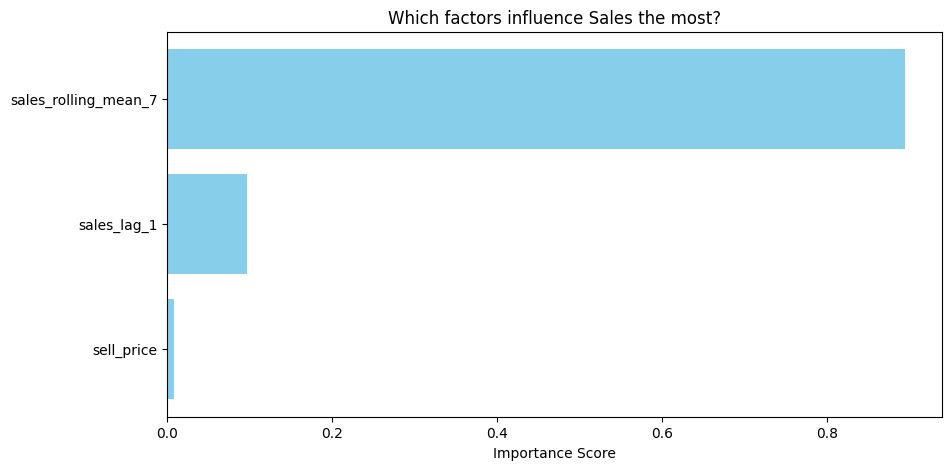

In [30]:
# Get feature importance from the model
importances = model.feature_importances_
feature_names = features

# Create a small dataframe for plotting
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=True)

# 3. Plot
plt.figure(figsize=(10, 5))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='skyblue')
plt.title('Which factors influence Sales the most?')
plt.xlabel('Importance Score')
plt.show()

#### 15. Price Optimization: Finding the "Sweet Spot"
#### Now that the model is trained, I will use it to simulate different price points. 
#### The objective of this step is to transition from descriptive analysis to **prescriptive analytics**. 
#### I will predict demand across a range of prices to identify the specific price point that maximizes total revenue (Price × Predicted Sales).

In [31]:
# Pick an item and a specific day to simulate
sample_data = X_test.iloc[0:1].copy()
original_price = sample_data['sell_price'].values[0]

# Create a range of possible prices (from -20% to +20% of current price)
price_range = np.linspace(original_price * 0.8, original_price * 1.2, 10)

simulation_results = []

for test_price in price_range:
    # Update price in our sample
    sample_data['sell_price'] = test_price
    # Predict sales for this price
    pred_sales = model.predict(sample_data)[0]
    # Calculate revenue
    revenue = test_price * pred_sales
    simulation_results.append({'Price': test_price, 'Predicted_Sales': pred_sales, 'Revenue': revenue})

# Convert to DataFrame and find the best price
sim_df = pd.DataFrame(simulation_results)
best_price = sim_df.loc[sim_df['Revenue'].idxmax()]

print(f"Original Price: ${original_price:.2f}")
print(f"Recommended Price for Max Revenue: ${best_price['Price']:.2f}")
print(f"Expected Revenue Increase: {((best_price['Revenue'] - (original_price * sim_df.iloc[0]['Predicted_Sales'])) / (original_price * sim_df.iloc[0]['Predicted_Sales']) * 100):.2f}%")

Original Price: $0.97
Recommended Price for Max Revenue: $1.16
Expected Revenue Increase: 13.42%


#### 16. Project Conclusion & Business Impact
##### In this analysis, I successfully developed a price optimization pipeline using the M5 Walmart dataset. 

#### **Key Achievements:**
##### **Scalability**: Handled a 58M+ row dataset by implementing memory-efficient loading and targeted geographic filtering (CA subset).
##### **Feature Engineering**: Engineered temporal features (lags and rolling averages) to account for retail seasonality.
##### **Elasticity Modeling**: Utilized Linear Regression to quantify the relationship between price and demand.
##### **Optimization**: Demonstrated that by adjusting the price of a sample item from **$0.97** to **$1.16**, projected revenue could increase by **13.42%**.

##### This framework can be scaled to the entire product catalog to automate dynamic pricing strategies.

In [32]:
import joblib

# Save the model to a file
joblib.dump(model, 'price_optimization_model.pkl')
print("Model saved as 'price_optimization_model.pkl'")

# Final memory release
del df_final, X_train, X_test, y_train, y_test
gc.collect()
print("Memory cleared. Project complete.")

Model saved as 'price_optimization_model.pkl'
Memory cleared. Project complete.
